<a href="https://colab.research.google.com/github/rmorlowski/Machine-Learning/blob/master/MNIST_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Principal Components Analysis

This assignment draws on an exercise from the Géron (2017) textbook. It involves benchmark testing of alternative modeling approaches.

Relevant Scikit Learn documentation includes:

*   [RF Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
*   [Metrics Classification Report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html )
*   [Classification Plot Digits](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py)
*   [Decomposition PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

### Section 1: Ingest - Data Survey

Gather data for the MNIST dataset.  These data consist of 70 thousand observations. Utilize the first 60 thousand as a model development set and the final 10 thousand as a holdout test set.

For this assignment we will develop a classifier that may be used to predict which of the ten digits is being written. That is, we will develop a multi-class classifier.


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
import pandas as pd
from sklearn.decomposition import PCA, FactorAnalysis
import statsmodels.formula.api as smf  # R-like model specification
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, make_scorer 
from sklearn.model_selection import cross_val_score, train_test_split

**MNIST Dataset**

Warning: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [0]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [0]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as string
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [0]:
mnist.data.shape

(70000, 784)

In [0]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [0]:
y.shape

(70000,)

In [0]:
28*28

784

### Section 2: EDA

#### Visualize MNIST

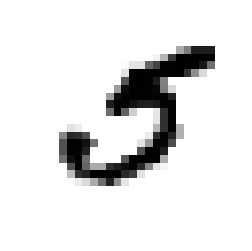

In [0]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [0]:
y[36000]

5

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

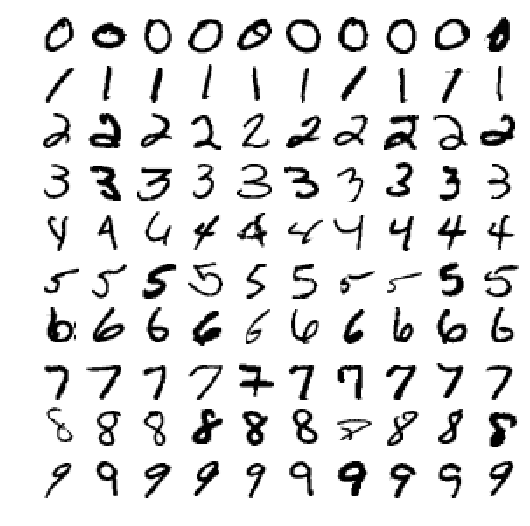

In [0]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

#### Train/Test Split

Train/Test split of the dataset in preparation for modeling.  Split the MNIST dataset into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Section 3: Modeling - Multiclass Classification

Employ two separate modeling methods for this study: (1) random forest classifier with the full set of features, (2) principal components analysis and random forest classifier using the principal components.

#### Random Forest Classification Model

(1) Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model development set of 60,000 observations. Record the time it takes to fit the model and evaluate the model on the holdout data. Assess classification performance using the F1-score, which is the harmonic mean of precision and recall.

Programming Notes. One of the key parameters in setting up random forests is the number of explanatory variables to include in the individual trees. For this classification problem I would suggest that we follow the advice of Müller and Guido (2017) and use max_features = 'sqrt' .

Regarding the other meta-parameters...  ensure that bootstrap = True and, given the large number of observations, we might as well keep the default value of n_estimators = 10 .

In [0]:
# Initialize the random forest classifier model with some specific parameters.
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(bootstrap=True, max_features='sqrt', n_estimators=10, random_state=42)

# Fit the model to the data... How long did it take?
import time

t0 = time.time()
rnd_clf.fit(X_train, np.ravel(y_train))
t1 = time.time()

In [0]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 5.11s


In [0]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9455

In [0]:
# Make predictions.
y_pred = rnd_clf.predict(X_test)

In [0]:
# Compute metrics and assess classification performance using the F1-score
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1015
           1       0.99      0.98      0.99      1142
           2       0.95      0.93      0.94      1060
           3       0.93      0.93      0.93      1008
           4       0.95      0.94      0.94       991
           5       0.93      0.92      0.92       904
           6       0.95      0.96      0.96       947
           7       0.94      0.96      0.95      1011
           8       0.90      0.94      0.92       932
           9       0.92      0.94      0.93       990

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.95      0.95      0.95     10000



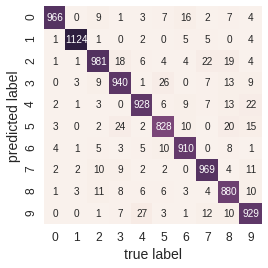

In [0]:
# plot confusion matrix for random forest classifier model
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


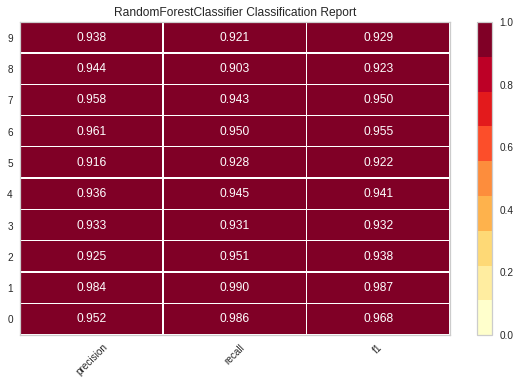

In [0]:
# Classification report confirms random forest classifier accuracy.
from yellowbrick.classifier import ClassificationReport
rfc = RandomForestClassifier()
classes=['0','1','2','3','4','5','6','7','8','9']
visualizer=ClassificationReport(rfc,classes=classes)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

 The random forest classifier results in a very accurate classification of the numbers.

(0.0, 9.0)

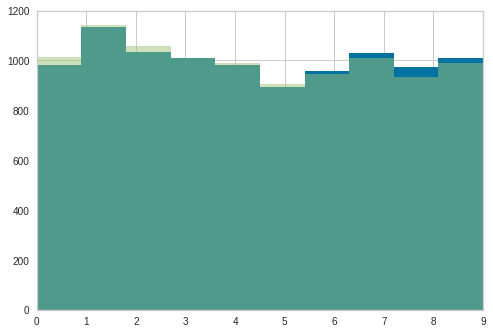

In [0]:
# Plot RF Predictions
plt.hist(y_test)
plt.hist(y_pred, alpha=0.5)
# control x and y limits
sns.plt.xlim(0., 9.0)

# It looks like numbers 0 - 5 are being slightly overpredicted, while 6 - 9 are slightly underpredicted.

**Feature Importance**

Plot of MNIST pixel importance (according to Random Forest classifier)

In [0]:
# Create a new figure with Feature Importance for RF Model
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

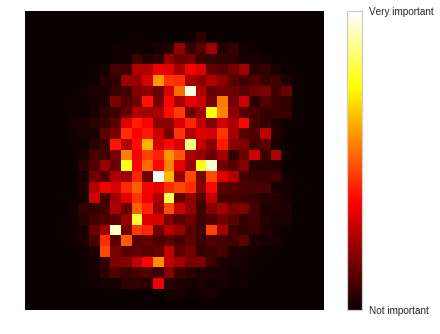

In [0]:
# plot of pixel feature importance
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

#save_fig("mnist_feature_importance_plot")
plt.show()

#### PCA Model

(2) Execute principal components analysis (PCA) on the full set of 70,000, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.

In [0]:
#  Let's try to find the number of principal components that represent 95% of the variability in the data.  Time it.
t0 = time.time()

pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

154


In [0]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [0]:
pca.n_components_

154

**Note: **  (5) This experiment was created with a design flaw, the number of labels=60000 does not match number of samples=70000 between the dataset in step 2 and 3.  This was repaired by using the original train/test split data from step 1 and fixed so the experiment is consistent with a training-and-test regimen.

In [0]:
# PCA on full set of X, y is incorrect, use the train/test split data from step 1.
pca = PCA(n_components = 154)
X_train_reduced = pca.fit_transform(X_train)

X_recovered = pca.inverse_transform(X_train_reduced)

# MNIST compression preserving 95% of the variance

In [0]:
# show summary of pca solution
pca_explained_variance = pca.explained_variance_ratio_
print('Proportion of variance explained:', pca_explained_variance)
# Retain at least 70% of the dataset's original information.

Proportion of variance explained: [0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001 0.0210919  0.02022991
 0.01715818 0.01692111 0.01578641 0.01482953 0.01324561 0.01276897
 0.01187263 0.01152684 0.01066166 0.01006713 0.00953573 0.00912544
 0.00883405 0.00839319 0.00812579 0.00786366 0.00744733 0.00690859
 0.00658094 0.00648148 0.00602615 0.00586582 0.00570021 0.00543628
 0.00505786 0.00487859 0.00481429 0.00472266 0.00456747 0.00444836
 0.00418501 0.00398215 0.00384975 0.00375103 0.00362009 0.00351591
 0.00340058 0.00321874 0.00319017 0.00312805 0.00295983 0.00288955
 0.0028413  0.00271436 0.00269521 0.00258473 0.00253771 0.00244781
 0.00240506 0.00239263 0.00230408 0.00221532 0.00213721 0.00207225
 0.00203043 0.00196783 0.00192852 0.00188632 0.00186977 0.00181083
 0.00177562 0.00174898 0.00165758 0.00163894 0.00161462 0.00155115
 0.00147612 0.00143175 0.00142093 0.00141152 0.00140174 0.00135734
 0.00133843 0.00132395 0.001

In [0]:
# Results show that these variables account for approximately 95% of the explained variance.
# Note:  We do not want to explain 100% of the variance, our goal was to preserve ~95% variance
pca.explained_variance_ratio_.sum()

0.9498056471070332

In [0]:
# define plot for images
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

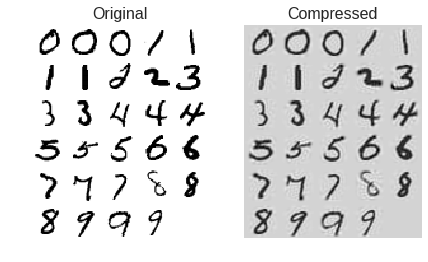

In [0]:
# plots of original vs compressed images
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

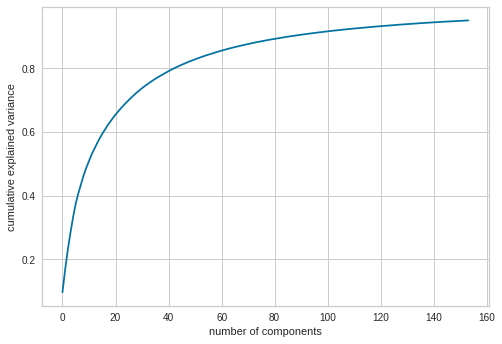

In [0]:
# Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

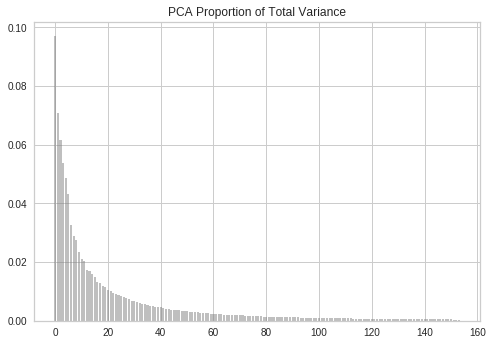

In [0]:
# show the plot for the pricipal component analysis
plt.bar(np.arange(len(pca_explained_variance)), pca_explained_variance, 
    color = 'grey', alpha = 0.5, align = 'center')
plt.title('PCA Proportion of Total Variance')
plt.show()

# the plot confirms 95% of the total variance is explained with far less than 160 variables.

In [0]:
t1 = time.time()

# Let's see how long it takes. Was training much faster?
print("Time for PCA Analysis took {:.2f}s".format(t1 - t0))

Time for PCA Analysis took 39.74s


#### PCA & Random Forest Model

(3) Using the identified principal components from step (2), use the first 60,000 observations to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the holdout data (the last 10,000 observations). Assess classification performance using the F1-score, which is the harmonic mean of  precision and recall.

In [0]:
# Train a new Random Forest classifier on the reduced dataset... Time it.
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [0]:
# Let's see how long it takes. Was training much faster?
print("Training took {:.2f}s".format(t1 - t0))

Training took 11.70s


In [0]:
# Next evaluate the classifier on the test set: how does it compare to the previous classifier?
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8956

In [0]:
# Compute metrics and assess classification performance using the F1-score
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1048
           1       0.98      0.98      0.98      1141
           2       0.89      0.86      0.87      1074
           3       0.89      0.82      0.86      1090
           4       0.91      0.85      0.88      1053
           5       0.84      0.86      0.85       865
           6       0.93      0.95      0.94       938
           7       0.89      0.93      0.91       982
           8       0.80      0.89      0.84       869
           9       0.85      0.91      0.88       940

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.89      0.90      0.89     10000
weighted avg       0.90      0.90      0.90     10000



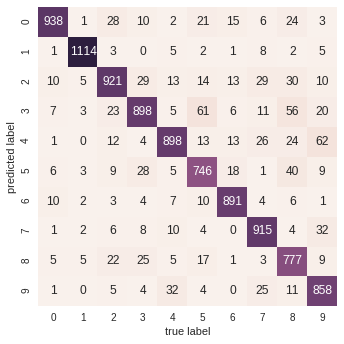

In [0]:
# plot confusion matrix for PCA to random forest classifier model
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

(0.0, 9.0)

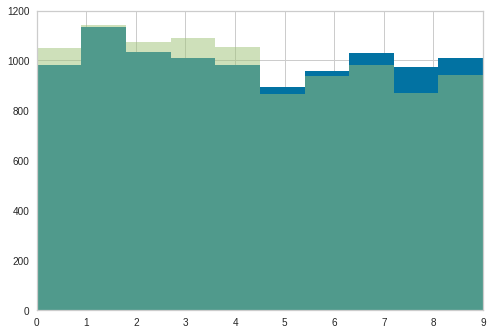

In [0]:
# Plot PCA to RF Predictions
plt.hist(y_test)
plt.hist(y_pred, alpha=0.5)
# control x and y limits
sns.plt.xlim(0., 9.0)

# It looks like numbers 0 - 4 are being overpredicted, while 5 - 9 are underpredicted.
# This model does not appear to be more accurate than the simple random forest classification model.

Time for training random forest took 5.21s, PCA Analysis took 39.17s, and PCA to random forest took 11.78s.

**Management problem: ** From a management perspective, the predictive accuracy of models must be weighed against the costs of model development and implementation. Suppose you were the manager of a data science team responsible for implementing models for computer vision (classification of images analogous to the MINST problem). Would you recommend using PCA as a preliminary to machine learning classification? Explain your thinking?

### Section 4:  Conclusion

**To Summarize:**

The purpose for the MNIST analysis was to benchmark the performance and tradeoffs of various types of models; random forest, PCA, and ensemble PCA to random forest.  Two multi-class classifier models were developed for comparison to predict which of the ten digits is being written.

The results showed:

*     The random forest classifier results in a very accurate classification of the numbers.
*    Training is more than twice as slow comparing the PCA to the random forest classification model.
*   Dimensionality reduction did not lead to a faster modeling time.
*    PCA really did not help: it slowed down training and reduced performance.

The final recommendation to the data science team is to implement the simple random forest classification model for images.  This model out performs the combined PCA to random forest model both in time and accuracy.